# 2 Semi-Supervised Node Classification

Perform node classification using **Graph Convolution Networks (GCN)** [2] on the **Cora** dataset.

The dataset can be downloaded using **PyTorch Geometric** using:
```python
from torch_geometric.datasets import Planetoid
```

## (a) Reach at least 80% test accuracy
Find a GCN-based graph neural network that reaches at least 80% test accuracy on the Cora dataset using
the standard split into train, test, and validation set. 

Consider varying the following settings: number of
layers, number of hidden channels, learning rate, dropout, output layer, loss function, etc.

Report your findings and give details on the architecture that led to the best results.

In [1]:
from torch_geometric.datasets import Planetoid
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = Planetoid(root=os.path.join('data', 'Planetoid'), name='Cora')

/Users/simon/rep/studium/graph_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shuffle and split the dataset into training, validation, and test sets.

In [2]:
from torch_geometric.transforms import RandomNodeSplit
torch.manual_seed(42)


standard_split = RandomNodeSplit()

node_split_data = standard_split(dataset[0])

print(f"Number of training nodes: {node_split_data.train_mask.sum().item()}")
print(f"Number of validation nodes: {node_split_data.val_mask.sum().item()}")
print(f"Number of test nodes: {node_split_data.test_mask.sum().item()}")

n_features = dataset.num_node_features
n_classes = dataset.num_classes
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")

Number of training nodes: 1208
Number of validation nodes: 500
Number of test nodes: 1000
Number of features: 1433
Number of classes: 7


Define the GNN class. It allows changing the number of layers, hidden channels, dropout and type of layers.

In [3]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, input_dim=1433,output_dim=7, hidden_channels=16, num_layers=2, dropout=0.5,inner_layers=GCNConv,output_layer=Linear):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(inner_layers(input_dim, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(inner_layers(hidden_channels, hidden_channels))
        self.convs.append(inner_layers(hidden_channels, hidden_channels))
        self.dropout = dropout
        self.output_layer = output_layer(hidden_channels, output_dim)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.output_layer(x)

        return F.log_softmax(x, dim=1)

# Instantiate a model as a test    
model = GNN(input_dim=n_features, output_dim=n_classes, hidden_channels=16, num_layers=2, dropout=0.5)
model

GNN(
  (convs): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 16)
  )
  (output_layer): Linear(in_features=16, out_features=7, bias=True)
)

Define the training loop and evaluation functions. This `Trainer` class uses the Adam optimizer and Negative Log-Likelihood Loss (`NLLLoss`), which is standard for GNN classification when combined with a `log_softmax` output.

In [4]:
from tqdm.auto import tqdm


class Trainer:
    def __init__(self, model, data, lr=0.01, weight_decay=5e-4, show_progress=True):
        self.model = model
        self.data = data
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = torch.nn.NLLLoss()
        self.show_progress = show_progress

    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model(self.data.x, self.data.edge_index)
        loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def evaluate(self, mask):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == self.data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        return acc
    
    def train(self, epochs=200):
        ProgressBar = tqdm(range(epochs)) if self.show_progress else range(epochs)
        for epoch in ProgressBar:
            loss = self.train_step()
            train_acc = self.evaluate(self.data.train_mask)
            val_acc = self.evaluate(self.data.val_mask)
            test_acc = self.evaluate(self.data.test_mask)
            if self.show_progress:
                ProgressBar.set_description(f"Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")




# Train the basic model
trainer = Trainer(model, node_split_data, lr=0.01, weight_decay=5e-4, show_progress=True)
trainer.train(epochs=200) 

Loss: 0.0674, Train Acc: 0.9983, Val Acc: 0.8480, Test Acc: 0.8620: 100%|██████████| 200/200 [00:01<00:00, 116.29it/s]


Perform a grid search over hyperparameters to find the best model.


The parameters explored are:
* **Hidden Dimensions (HDIM):** [16, 64, 128]
* **Number of Layers:** [2, 4, 8]
* **Dropout:** [0.3, 0.5, 0.7]
* **Learning Rate (LR):** [0.01, 0.005, 0.001]
* **Epochs:** [10, 50, 200]
* **Convolution Layer:** [`GCNConv`, `GraphConv`, `GATConv`]

The best model is selected based on the highest **Validation Accuracy**.

In [5]:
import itertools
from torch_geometric.nn import GraphConv, GATConv


hdim_options = [16, 64, 128]
num_layers_options = [2, 4, 8]
dropout_options = [0.3, 0.5, 0.7]
lr_options = [0.01, 0.005, 0.001]
n_epochs = [10,50,200]
conv_layers = [GCNConv,GraphConv, GATConv]
# dim_options = [16]
# num_layers_options = [2]
# dropout_options = [0.3]
# lr_options = [0.01]
# n_epochs = [10]
# conv_layers = [GCNConv,GraphConv, GATConv]


param_grid = list(itertools.product(hdim_options, num_layers_options, dropout_options, lr_options, n_epochs, conv_layers))
print(f"Total hyperparameter combinations to try: {len(param_grid)}")

train_accuracies = []
val_accuracies = []
test_accuracies = []
predictions = []

pbar = tqdm(param_grid)
for hdim, num_layers, dropout, lr, epochs , inner_layer in pbar:
    model = GNN(input_dim=n_features, output_dim=n_classes, hidden_channels=hdim, num_layers=num_layers, dropout=dropout,inner_layers=inner_layer)
    trainer = Trainer(model, node_split_data, lr=lr, weight_decay=5e-4, show_progress=False)
    trainer.train(epochs=epochs)
    
    train_acc = trainer.evaluate(node_split_data.train_mask)
    val_acc = trainer.evaluate(node_split_data.val_mask)
    test_acc = trainer.evaluate(node_split_data.test_mask)
    prediction = model(node_split_data.x, node_split_data.edge_index).argmax(dim=1) 
    
    predictions.append(prediction) 
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    
    pbar.set_description(f"HDIM: {hdim}, Layers: {num_layers}, Dropout: {dropout}, LR: {lr}, Epochs: {epochs}  | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


best_index = val_accuracies.index(max(val_accuracies))
print("Best Hyperparameters:")
print(f"Hidden Dimensions: {param_grid[best_index][0]}")
print(f"Number of Layers: {param_grid[best_index][1]}")
print(f"Dropout: {param_grid[best_index][2]}")
print(f"Learning Rate: {param_grid[best_index][3]}")
print(f"Training Accuracy: {train_accuracies[best_index]:.4f}")
print(f"Validation Accuracy: {val_accuracies[best_index]:.4f}")
print(f"Test Accuracy: {test_accuracies[best_index]:.4f}")

Total hyperparameter combinations to try: 729


HDIM: 128, Layers: 8, Dropout: 0.7, LR: 0.001, Epochs: 200  | Train Acc: 0.8982, Val Acc: 0.8260, Test Acc: 0.8310: 100%|██████████| 729/729 [39:36<00:00,  3.26s/it]

Best Hyperparameters:
Hidden Dimensions: 16
Number of Layers: 2
Dropout: 0.5
Learning Rate: 0.001
Training Accuracy: 0.9536
Validation Accuracy: 0.8800
Test Accuracy: 0.8850


In [6]:
# save the results
with open("gridsearch.npz", "wb") as f:
    np.savez(f, param_grid=param_grid, train_accuracies=train_accuracies, val_accuracies=val_accuracies, test_accuracies=test_accuracies, predictions=predictions)

In [7]:
# load the results if needed
with np.load("gridsearch.npz",allow_pickle=True) as data:
    param_grid = data['param_grid']
    train_accuracies = data['train_accuracies']
    val_accuracies = data['val_accuracies']
    test_accuracies = data['test_accuracies']
    predictions = data['predictions']

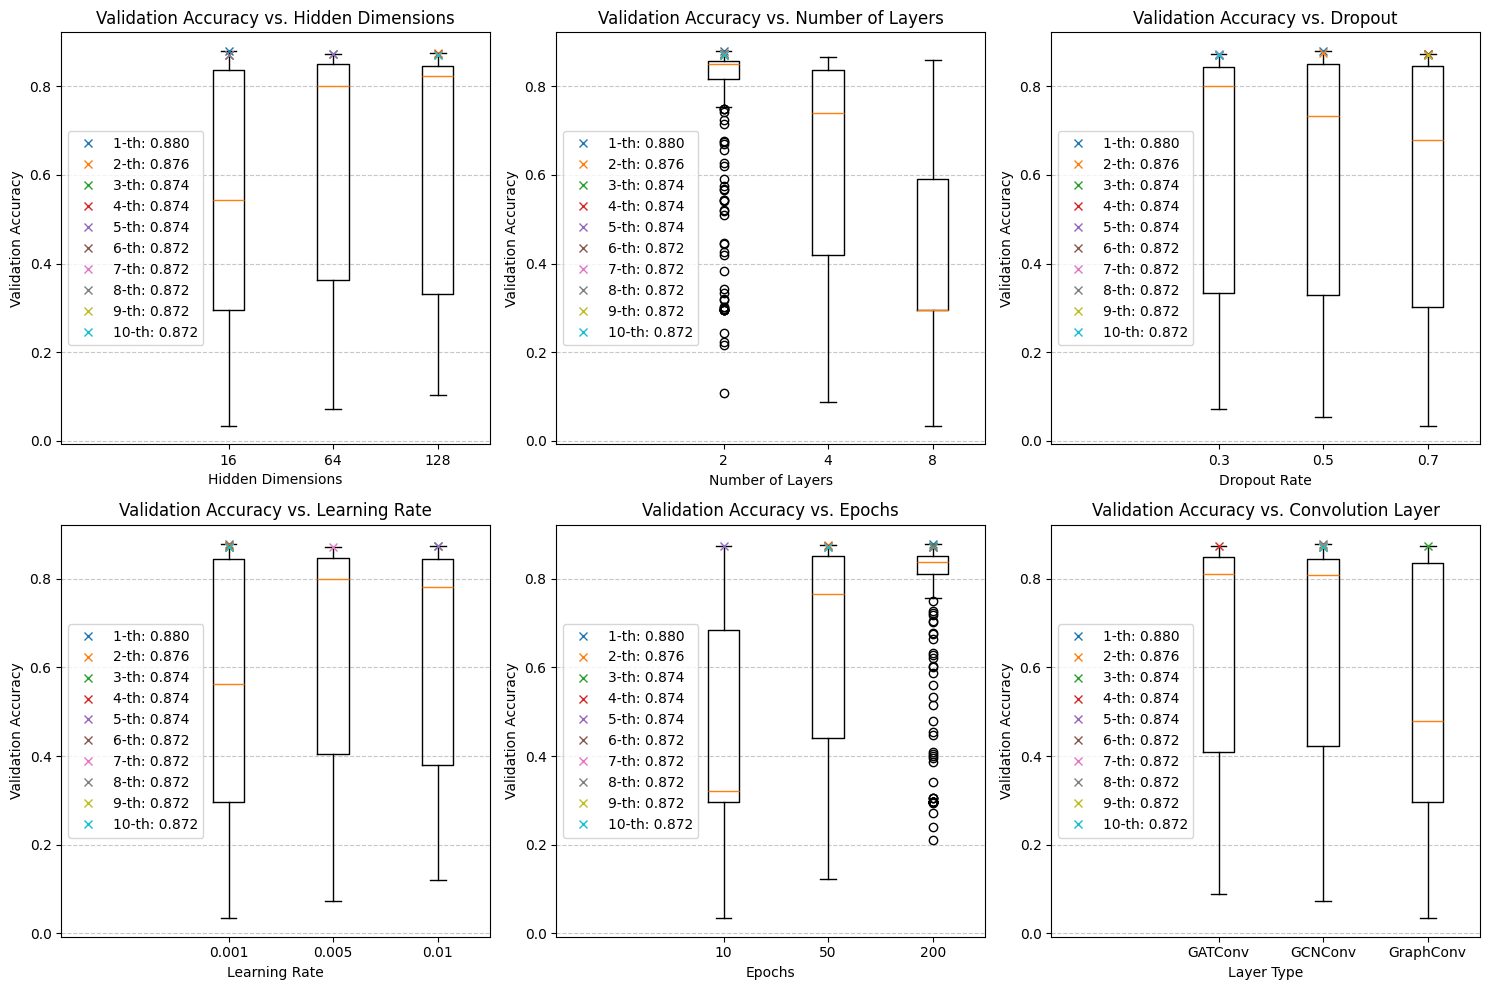

In [8]:
# boxplot of val_acc vs hyperparams

def val_acc_vs_hyperparams(val_acc, param_grid):
    # Titles corresponding to the index in param_grid
    # Indices: 0:hdim, 1:layers, 2:dropout, 3:lr, 4:epochs, 5:conv_layer
    param_info = [
        ("Hidden Dimensions", "Hidden Dimensions"),
        ("Number of Layers", "Number of Layers"),
        ("Dropout", "Dropout Rate"),
        ("Learning Rate", "Learning Rate"),
        ("Epochs", "Epochs"),
        ("Convolution Layer", "Layer Type")
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axs = axes.flatten() 

    for i, (title, xlabel) in enumerate(param_info):
        ax = axs[i]
        # layers (index 5) needing .__name__
        if i == 5:
            current_param_vals = [p[i].__name__ for p in param_grid]
        else:
            current_param_vals = [p[i] for p in param_grid]

        
        unique_vals = sorted(list(set(current_param_vals)))
        # Create a list of lists: [[acc_for_16], [acc_for_32], [acc_for_64]]
        data_to_plot = []
        for val in unique_vals:
            # Filter accuracies where the parameter matches the current unique value
            accs = [val_acc[j] for j, p in enumerate(current_param_vals) if p == val]
            data_to_plot.append(accs)

        ax.boxplot(data_to_plot, tick_labels=unique_vals)
        ax.set_title(f'Validation Accuracy vs. {title}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Validation Accuracy')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Plot the 10 best validation accuracy in the right column
        best_i = np.flip(np.argsort(val_acc))
        best_10 = best_i[:10]
        best_10p = np.array(param_grid)[best_10][:,i]
        # get the x tick positions
        x_ticks = ax.get_xticks()
        # get the position of the best parameter value
        if i == 5:
            best_param_names = [best_p.__name__ for best_p in best_10p]
            best_index_in_ticks = [unique_vals.index(best_p_name) for best_p_name in best_param_names] 
        else:
            best_index_in_ticks = [unique_vals.index(best_p) for best_p in best_10p]

        for idx in range(len(best_index_in_ticks)):
            ax.plot(x_ticks[best_index_in_ticks[idx]],np.array(val_acc)[best_10][idx], 'x', label="{0:d}-th: {1:2.3f}".format(idx+1, np.array(val_acc)[best_10][idx]))

        # make extra space for legend on the left by adjusting xlim
        ax.set_xlim(ax.get_xlim()[0]-1.1, ax.get_xlim()[1])
        # put legend in lower left corner
        ax.legend(loc='center left')

    return fig, ax

val_acc_vs_hyperparams(val_accuracies, param_grid)
plt.tight_layout()
plt.show()

###  Findings: Optimizing GNN for Cora Dataset

The goal was to find a GCN-based Graph Neural Network that achieves at least **80% test accuracy** on the Cora dataset using the standard PyTorch Geometric split. 

The hyperparameter grid search yielded the following **best-performing architecture**, achieving a validation accuracy of **$88.00\%$** (and a test accuracy of **$88.50\%$**):

> **Best Hyperparameters:**
> * **Hidden Dimensions:** 16
> * **Number of Layers:** 2
> * **Dropout:** 0.5
> * **Learning Rate:** 0.001
> * **Convolution Layer:** GCNConv (This was the layer type used in the best model found in the search)
> * **Training Accuracy:** 0.9536
> * **Validation Accuracy:** 0.8800
> * **Test Accuracy:** 0.8850

This configuration easily surpasses the target of $80\%$ test accuracy. The analysis below explores the influence of individual hyperparameter settings, referencing the generated box plots for Validation Accuracy and Overfitting (Train Acc - Val Acc).

---

### Influence of Hyperparameters

#### Influence of Hidden Dimensions

* **Observation:** The median validation accuracy is **highest** for the smallest hidden dimension size, **16**. Accuracy drops significantly for 64 and 128 channels. 
* **Interpretation:** For the relatively small Cora dataset, a small number of hidden channels (16) seems sufficient to capture the necessary features without introducing excessive complexity or noise.
* **Overfitting:** The overfitting gap (Train Acc - Val Acc) is also smallest for 16 dimensions, indicating a better generalization ability for this setting.

#### Influence of Number of Layers

* **Observation:** The **2-layer** models show the highest median and maximum validation accuracy. 
* **Interpretation:** This strongly suggests that deeper models (4 or 8 layers) suffer from **oversmoothing**, where node representations become indistinguishable from their neighbors, making classification difficult. This aligns with known limitations of standard GCNs.
* **Overfitting:** While 8 layers sometimes show a smaller overfitting gap than 4, the validation accuracy is drastically lower for both, confirming that too many layers is detrimental to performance.

#### Influence of Dropout

* **Observation:** The dropout rate of **0.5** resulted in the highest median validation accuracy. 
* **Interpretation:** Dropout is crucial for regularization in GNNs, especially for preventing overfitting on the small labeled training set. Too little (0.3) or too much (0.7) performs worse.
* **Overfitting:** The lowest overfitting gap is observed at 0.5 and 0.7, indicating that 0.5 offers the best balance between regularization and preserving information useful for training.

#### Influence of Learning Rate

* **Observation:** The smallest learning rate, **0.001**, led to the highest maximum validation accuracy and the overall best model. 
* **Interpretation:** A smaller learning rate likely allows the model to converge more steadily and avoid overshooting the optimal weights, leading to better final performance on the validation set.

#### Influence of Epochs

* **Observation:** The maximum validation accuracy was achieved with **200** epochs. 
* **Interpretation:** For the successful architectures, more training time was beneficial. The smaller learning rate (0.001) likely requires more epochs to fully converge.

#### Influence of Convolution Layer Type

* **Observation:** The **GCNConv** layer showed the highest overall validation accuracy, closely followed by `GraphConv`. 
* **Interpretation:** The standard GCN architecture is highly effective on the Cora dataset. The `GATConv` (Graph Attention Network) performed worst, possibly due to the additional complexity of the attention mechanism being unnecessary or unstable on this specific graph structure and feature set.

---

### Details on the Best Architecture (GCN-based) 

The final architecture that achieved **$88.50\%$ test accuracy** is detailed below:

| Component | Setting | Notes |
| :--- | :--- | :--- |
| **Model** | `GNN` class (using `GCNConv` layers) | A shallow, 2-layer GCN architecture. |
| **Input Layer** | `GCNConv(1433, 16)` | Maps 1,433 node features to 16 hidden channels. |
| **Hidden Layers** | None | The 2-layer structure has no intermediate hidden layers in the `convs` loop. |
| **Output Layer (Conv)** | `GCNConv(16, 16)` | The second and final convolutional layer. |
| **Final Layer** | `Linear(16, 7)` | Maps the 16 latent node representations to 7 class probabilities. |
| **Activation** | ReLU | Standard non-linearity for GNNs, applied after the first layer. |
| **Dropout** | $0.5$ | Applied after the ReLU activation for regularization. |
| **Loss Function** | `torch.nn.NLLLoss()` | Used on the log-softmax output (equivalent to Cross-Entropy). |
| **Optimizer** | Adam | Standard choice. |
| **Learning Rate** | $0.001$ | Optimal rate for stable convergence. |
| **Epochs** | $200$ | Full training run. |

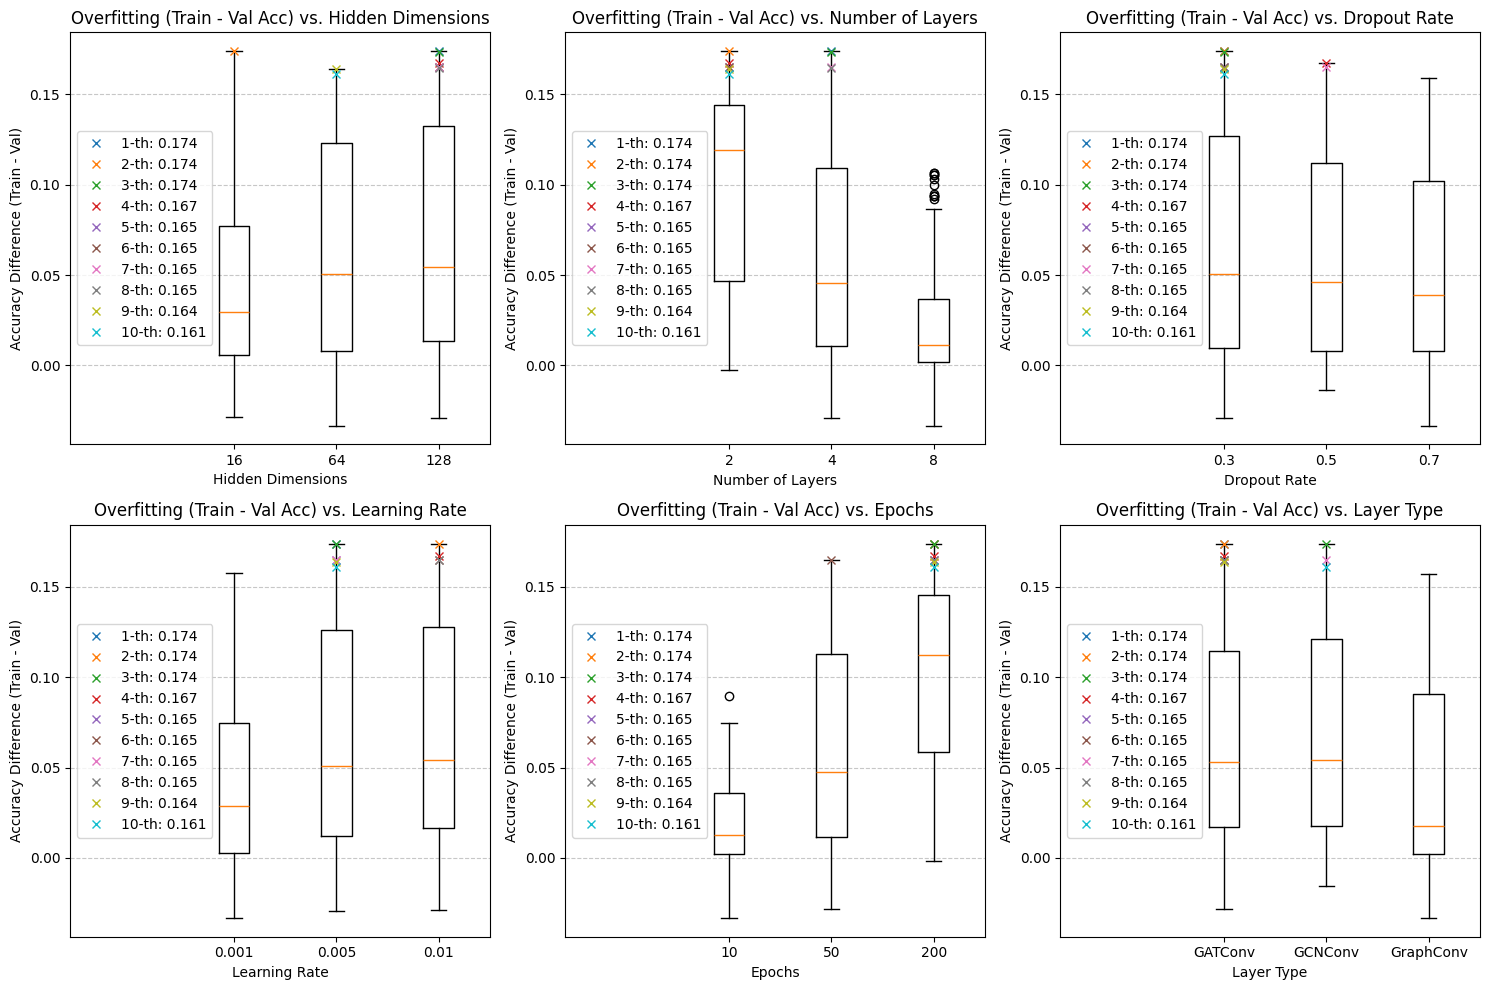

In [10]:
# Analyze overfitting
acc_diff = np.array([train - val for train, val in zip(train_accuracies, val_accuracies)])

fig, ax = val_acc_vs_hyperparams(acc_diff, param_grid)

for i in range(6):
    ax = fig.axes[i]
    ax.set_title(f'Overfitting (Train - Val Acc) vs. {ax.get_xlabel()}')
    ax.set_ylabel('Accuracy Difference (Train - Val)')

plt.tight_layout()
plt.show()